<a href="https://colab.research.google.com/github/KauaHenSilva/python_vdo_facial_detection/blob/main/SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [120]:
from google.colab.drive import mount
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import time

In [121]:
# drive: https://drive.google.com/drive/folders/1OXTbhGlG6Y-x6hMY_5Y8Ed3mPB9lP5LF?usp=sharing
mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Detecção de faces em vidio com Haar cascade (OpenCV)


In [122]:
video_path = "/content/drive/MyDrive/Face Detection and Recognition/videos/video01.mp4"
video_cap = cv2.VideoCapture(video_path)

In [123]:
conectado, video = video_cap.read()
print(conectado)
print(video.shape)

True
(1080, 1920, 3)


In [124]:
video_largura = video.shape[1]
video_altura = video.shape[0]
print(f"{video_largura}x{video_altura}")

1920x1080


## Redimencionar

In [125]:
largura_maxima = 900

In [126]:
def redimencionar(largura, altura, largura_maxima = 600):
  if largura > largura_maxima:
      proporcao = largura / altura
      video_largura = largura_maxima
      video_altura = int(video_largura / proporcao)
  else:
      video_largura = largura
      video_altura = altura
  return video_largura, video_altura

In [127]:
if largura_maxima is not None:
  video_largura, video_altura = redimencionar(video_largura, video_altura, largura_maxima)
video_largura, video_altura

(900, 506)

## Configuração do vídeo

In [128]:
arquivo_resultado = 'resultado.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 24
video_saida = cv2.VideoWriter(arquivo_resultado, fourcc, fps, (video_largura, video_altura))

## Deteccao

In [129]:
prototxt = "/content/drive/MyDrive/Face Detection and Recognition/weights/deploy.prototxt.txt"
model = "/content/drive/MyDrive/Face Detection and Recognition/weights/res10_300x300_ssd_iter_140000.caffemodel"
network = cv2.dnn.readNetFromCaffe(prototxt, model)

In [130]:
def detectar_ssd(net, img, show_conf=True, tamanho=300, conf_min=0.7):
  (h, w) = img.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(img, (tamanho, tamanho)), 1.0, (tamanho, tamanho), (104.0, 117, 123.0))
  net.setInput(blob)
  deteccoes = net.forward()

  for i in range(0, deteccoes.shape[2]):
    confianca = deteccoes[0, 0, i, 2]
    if confianca > conf_min:
      box = deteccoes[0, 0, i, 3:7] * np.array([w, h, w, h])
      (start_x, start_y, end_x, end_y) = box.astype("int")

      cv2.rectangle(img, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
      if show_conf:
        text_conf = "{:.2f}%".format(confianca * 100)
        cv2.putText(img, text_conf, (start_x, start_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 2)

  return img


## Processar video

In [131]:
frames_show = 4
frame_atual = 1
max_frame = -1

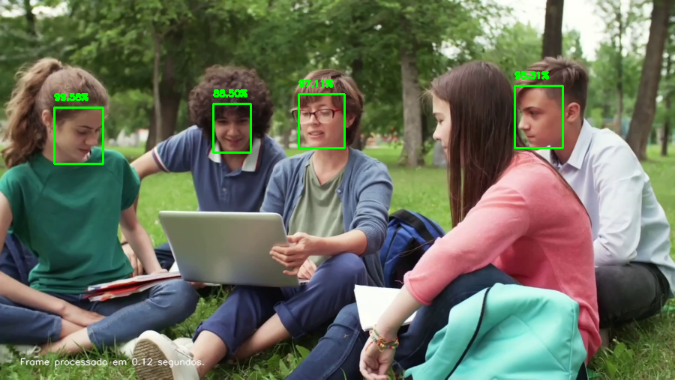

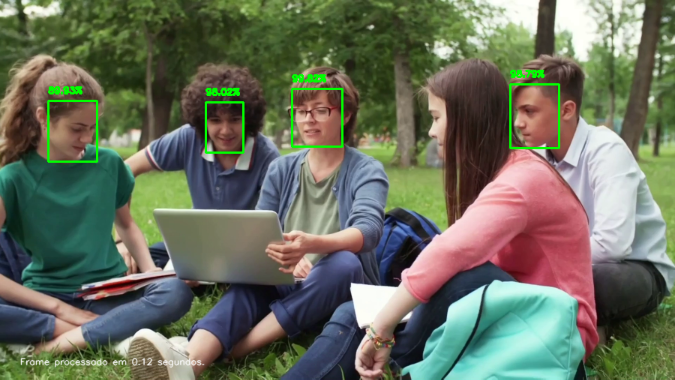

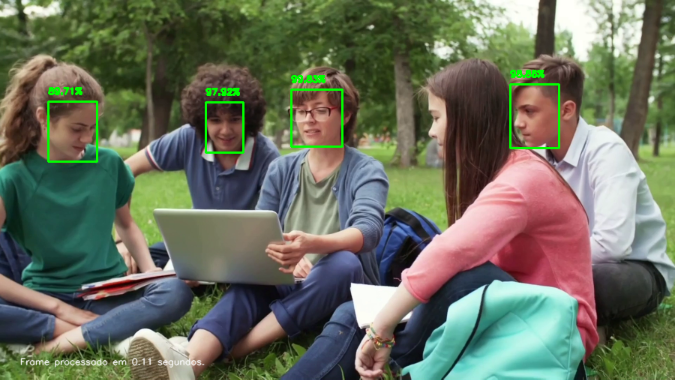

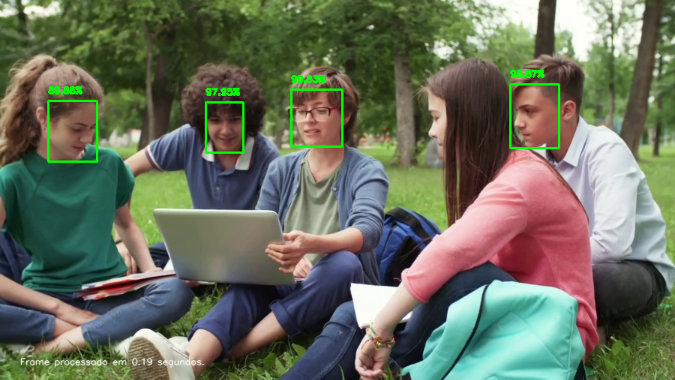

In [132]:
while cv2.waitKey(1) < 0:
  conectado, frame = video_cap.read()

  if not conectado:
    break
  if max_frame > -1 and frame_atual > max_frame:
    break

  t = time.time()
  (l, a) = frame.shape[:2]
  if largura_maxima is not None:
    frame = cv2.resize(frame, (video_largura, video_altura))

  frame_processado = detectar_ssd(network, frame)

  cv2.putText(frame_processado, f" Frame processado em {(time.time() - t):.2f} segundos.", (20, video_altura - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (250, 250, 250), 0, lineType=cv2.LINE_AA)
  if frame_atual <= frames_show:
    cv2_imshow(cv2.resize(frame_processado, (0, 0), fx=0.75, fy=0.75))

  video_saida.write(frame_processado)

  frame_atual += 1

video_saida.release()
cv2.destroyAllWindows()

## Show

In [133]:
!ffmpeg -y -loglevel panic -i resultado.avi resultado.mp4

In [134]:
def show_video(name_file, width=700, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(name_file, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="Video" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

In [135]:
show_video('resultado.mp4')
